# Practical Session: From Pre-trained transformers to Chatbots

![Chatbot Illustration !](LLM_Session2/Images/chatbot.jpg "Designed by www.freepik.com")


### Objective

Welcome to our hands-on session, **"From Pre-trained to Chatbot"**! In this practical session, we'll transform a pre-trained GPT-2 model into a functional chatbot using the `multi_woz_v22` dataset. By the end of this workshop, you will have gained hands-on experience in:

- Understanding the mechanics behind a transformer-based chatbot.
- Preprocessing and formatting dialogue data for training.
- Fine-tuning GPT-2 to generate meaningful, task-oriented dialogue.

Ready? Let's dive in!

---

#### Necessary steps, run the hidden cells

In [13]:
# Load the necessary libraries
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, GPT2LMHeadModel,AutoTokenizer
from transformers import logging as transformers_logging
from datasets import load_dataset  
from torchinfo import summary
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import transformers
import torch
import json
import random
import warnings
import logging
import sys, os
import wget
import matplotlib.image as mpimg
from packaging import version


##### Where are you working?

If you are working on Jupyter lab, our recomandation, choose `jupyter`

In [2]:
# Confirm you have the right versions
platform = "laptop"  # possible choices are "jupyter", "laptop" and "curnagl"

# Define paths based on the platform
if platform in ["jupyter", "laptop", "curnagl"]:
    PATH_MODELS = "./LLM_Session2/Models"
    PATH_RESULTS = "./LLM_Session2/Results/"
else:
    raise ValueError("Invalid platform. Please choose from 'jupyter', 'laptop', or 'curnagl'.")
# Ensure directories exist
os.makedirs(PATH_MODELS, exist_ok=True)
os.makedirs(PATH_RESULTS, exist_ok=True)


In [3]:
# Confirm you have the right versions 
# Minimum required versions
required_versions = {
    "python": "3.10.15",
    "torch": "2.3.0",
    "transformers": "4.41.2",
    "numpy": "1.26.4"
}

# Fetch current versions
current_versions = {
    "python": sys.version.split()[0],
    "torch": torch.__version__,
    "transformers": transformers.__version__,
    "numpy": np.__version__
}

print("Version Check:")
for package, required_version in required_versions.items():
    current_version = current_versions[package]
    
    # Compare versions
    if version.parse(current_version) >= version.parse(required_version):
        print(f"{package}: {current_version} (✔)")
    else:
        print(f"{package}: {current_version} (✘) - Requires: {required_version} or later")


Version Check:
python: 3.10.15 (✔)
torch: 2.3.0+cu121 (✔)
transformers: 4.41.2 (✔)
numpy: 1.26.4 (✔)


In [4]:
# Try to use GPUs if available:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# Suppress some specific logging and warnings from transformers and Hugging Face Hub modules:
warnings.filterwarnings("ignore", category=FutureWarning, module="huggingface_hub.file_download")
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
transformers_logging.set_verbosity_error()

Using device: cuda


In [5]:
# Set a seed, to make the whole pipeline reproducible:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
transformers.set_seed(seed)

## 1. Our Datasets

The `multi_woz_v22` dataset is a comprehensive, multi-domain dialogue dataset, ideal for training task-oriented chatbots. It contains over 10,000 dialogues spanning various domains, such as **restaurant booking, hotel reservations, taxi services, and more**.

### Dataset Structure

Each dialogue in [`multi_woz_v22`](https://huggingface.co/datasets/pfb30/multi_woz_v22) contains:
- **User Utterances**: Statements or questions from the user, e.g., "Can you book a hotel for me?"
- **System Responses**: Replies from the system, e.g., "Sure, which city are you looking for?"
- **Metadata**: Information about the dialogue's domain, state, and other contextual details.

In addition to `multi_woz_v22`, we have created our own, complementary dataset with conversations featuring a distinct distribution. This smaller dataset complements `multi_woz_v22` and focuses on topics such as jokes, general introductions, and descriptions of some British landmarks. This dataset can be tailored to meet specific requirements.

### Sample Dialogue

Below is a code snippet to visualize a sample dialogue from the dataset:

```python
from datasets import load_dataset

# Load the multi_woz_v22 dataset
dataset = load_dataset("multi_woz_v22")
print(dataset['train'][0])  # Display the first example in the training set


We are going to use the Multi-Domain Wizard-of-Oz dataset (MultiWOZ). This is a fully-labeled collection of human-human written conversations spanning over multiple domains and topics. See https://huggingface.co/datasets/pfb30/multi_woz_v22 and https://arxiv.org/abs/1810.00278.

Load the "MultiWOZ" dataset:

In [6]:
# URL of the file to download
url = "https://drive.google.com/uc?id=1bJxwIM2nMuvkOyQBpjF65y0eEvMy5Qkg"

# Directory where the file will be stored
directory = "LLM_Session2"


# Path to the output file
output_filepath = os.path.join(directory, "complementary_data.json")

# Check if the file already exists
if not os.path.exists(output_filepath):
    print(f"{output_filepath} not found. Downloading...")
    # Download the file
    try:
        wget.download(url, output_filepath)
        print(f"\nDownloaded {output_filepath} successfully.")
    except Exception as e:
        print(f"An error occurred while downloading the file: {e}")
        raise
else:
    print(f"{output_filepath} already exists. Skipping download.")

# Load the data
try:
    with open(output_filepath, 'r') as file:
        complementary_data = json.load(file)
    print(f"Data loaded successfully from {output_filepath}.")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    raise

LLM_Session2/complementary_data.json not found. Downloading...

Downloaded LLM_Session2/complementary_data.json successfully.
Data loaded successfully from LLM_Session2/complementary_data.json.


In [7]:
complementary_data[0]

{'id': 0,
 'speaker': [0, 1],
 'utterance': ['Hello! What kind of help can you offer here?',
  'Hi there! I provide information about London, including directions, attractions, transportation, and local tips. How can I assist you?']}

In [8]:
# Load dataset from Hugging Face
dataset = load_dataset('multi_woz_v22', trust_remote_code=True)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 8437
    })
    validation: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialogue_id', 'services', 'turns'],
        num_rows: 1000
    })
})


In [9]:
# Look at an example:
example = dataset['train'][0]
print(example)

{'dialogue_id': 'PMUL4398.json', 'services': ['restaurant', 'hotel'], 'turns': {'turn_id': ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'], 'speaker': [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1], 'utterance': ['i need a place to dine in the center thats expensive', 'I have several options for you; do you prefer African, Asian, or British food?', 'Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation?', 'There is an Afrian place named Bedouin in the centre. How does that sound?', 'Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel?', "Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town.", 'Yes. Can you book it for me?', 'Sure, when would you like that reservation?', 'i want to book it for 2 people and 2 nights starting from saturday.', 'Your booking was successful. Your reference number is FRGZWQL2 . May I help you

### 1.2 Special Tokens and Why They Matter

When working with conversational data, it’s crucial to use special tokens to help the model understand the structure of the dialogue. These tokens act as **guidelines** for the model to differentiate between user and system turns and know when the conversation ends.

#### Our Special Tokens

We'll be using the following special tokens:

- **`<|user|>`**: Indicates the beginning of a user utterance.
- **`<|system|>`**: Indicates the beginning of a system (chatbot) response.
- **`<|endofturn|>`**: Marks the end of each dialogue turn.
- **`<|pad|>`**: Used to pad sequences to the same length for batch processing.

#### Why Are Special Tokens Important?

1. **Clarifying Speaker Roles**: In a conversation, distinguishing who is speaking (user or system) is essential for the model to learn appropriate response patterns.
2. **Defining Turn Boundaries**: By marking the end of a dialogue turn, we ensure the model can process and structure conversations more effectively.
3. **Efficient Padding**: The `<|pad|>` token ensures that input sequences are uniformly sized, making batch processing efficient and reducing computational load.


In [10]:
# Define special tokens 

user="<|user|>"
system= "<|system|>"
pad="<|pad|>"
eot="<|endofturn|>"

In [11]:
# Visualize a conversation in the dataset.

dialogue = example["turns"]

for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
    if speaker == 0:  # User input
        print(f" {user} {utterance.strip()} ")
    elif speaker == 1:  # System response
        print(f" {system} {utterance.strip()}")

 <|user|> i need a place to dine in the center thats expensive 
 <|system|> I have several options for you; do you prefer African, Asian, or British food?
 <|user|> Any sort of food would be fine, as long as it is a bit expensive. Could I get the phone number for your recommendation? 
 <|system|> There is an Afrian place named Bedouin in the centre. How does that sound?
 <|user|> Sounds good, could I get that phone number? Also, could you recommend me an expensive hotel? 
 <|system|> Bedouin's phone is 01223367660. As far as hotels go, I recommend the University Arms Hotel in the center of town.
 <|user|> Yes. Can you book it for me? 
 <|system|> Sure, when would you like that reservation?
 <|user|> i want to book it for 2 people and 2 nights starting from saturday. 
 <|system|> Your booking was successful. Your reference number is FRGZWQL2 . May I help you further?
 <|user|> That is all I need to know. Thanks, good bye. 
 <|system|> Thank you so much for Cambridge TownInfo centre. Hav

In [12]:
# Visualize a conversation in the complementary-dataset.
# This dataset is much smaller and only has one turn.

dialogues = complementary_data[10:30]

for dialogue in dialogues:
    print(f" {user} {dialogue['utterance'][0]} ")
    print(f" {system} {dialogue['utterance'][1]}")
    print(50*'-')

 <|user|> Can you help me find the nearest Tube station? 
 <|system|> Of course! The closest Tube station is just two blocks away on your left. Would you like a map?
--------------------------------------------------
 <|user|> How do I get to Buckingham Palace from here? 
 <|system|> Head south for about 15 minutes, or you can take the Victoria Line to Green Park Station and walk from there.
--------------------------------------------------
 <|user|> Which bus should I take to get to the British Museum? 
 <|system|> The number 14 bus will take you directly there. You can catch it from the stop just around the corner.
--------------------------------------------------
 <|user|> How do I get to Tower Bridge? 
 <|system|> Take the District Line to Tower Hill Station, then it’s just a short walk from there.
--------------------------------------------------
 <|user|> Where can I catch the Thames Clippers? 
 <|system|> You can catch the Thames Clippers from the Embankment Pier, just a 10-m

##### Example Explanation

Here the special tokens `'<|user|>'` and `'<|system|>'` help GPT-2 to differentiate between different speakers in a conversation, facilitating the model’s ability to learn how a dialogue typically unfolds. By labeling input text with `'<|user|>'` for the human’s part of the conversation and `'<|system|>'` for the chatbot’s response, you give the model a clear format. This will help it understand conversational roles and can also improve the training of dialogue models.

GPT-2 will learn the conversational flow, that is the back-and-forth nature of conversation, and be able to generate coherent dialogue after training. In summary, GPT-2 will generate next words in such a way to mimic a conversation.

Load the pre-trained GPT-2 tokenizer and add special tokens:

In [13]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
special_tokens_dict = {
    "additional_special_tokens": [user,system,eot],
    "pad_token": "<|pad|>",
}
tokenizer.add_special_tokens(special_tokens_dict)

4

#### Analyse the dataset

In [14]:
examples = dataset['train']

dialogues = []
for dialogue in examples['turns']:
    dialogue_text = ""
    for turn_id, speaker, utterance in zip(dialogue["turn_id"], dialogue["speaker"], dialogue["utterance"]):
        if speaker == 0:  # User input
            dialogue_text += f"{user} {utterance.strip()} "
        elif speaker == 1:  # System response
            dialogue_text += f"{system} {utterance.strip()} "
    dialogues.append(dialogue_text)

In [15]:
print("The number of dialogues in the dataset: ", len(dialogues))

The number of dialogues in the dataset:  8437


Plot a histogram of the number of tokens in each dialogue:

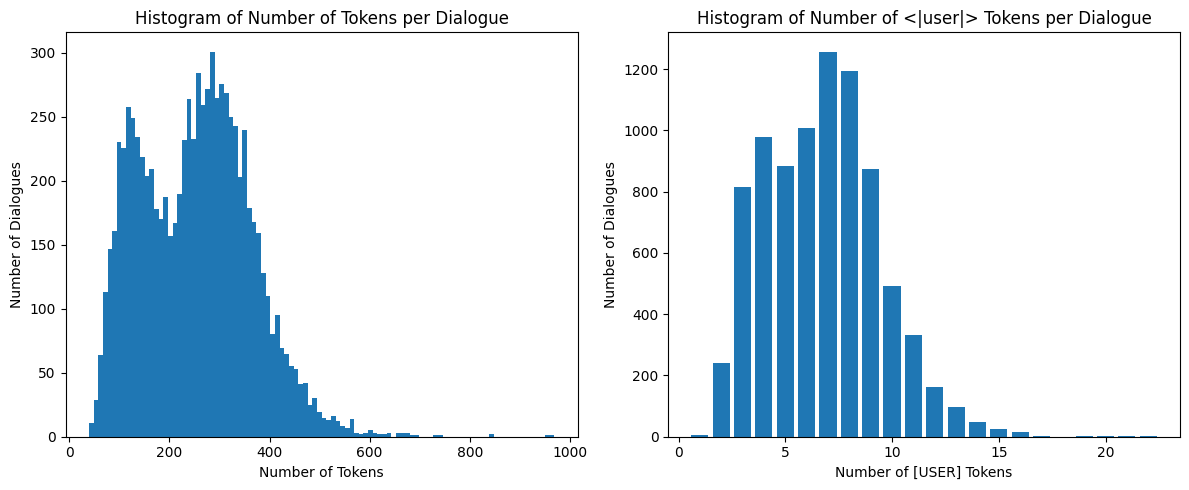

In [16]:
def plot_token_histogram(dialogues, tokenizer, num_bins=10):

    # Tokenizing the dialogues and counting tokens in each dialogue
    num_tokens_per_dialogue = [len(tokenizer.tokenize(dialogue)) for dialogue in dialogues]

    # Create histogram bins
    token_min = min(num_tokens_per_dialogue)
    token_max = max(num_tokens_per_dialogue)
    bins = np.linspace(token_min, token_max, num_bins + 1)  # Create `num_bins` equally spaced bins

    # Count occurrences of each token count
    token_counts, _ = np.histogram(num_tokens_per_dialogue, bins=bins)

    # Count occurrences of [USER] in each dialogue
    num_user_tokens_per_dialogue = [dialogue.count(user) for dialogue in dialogues]
    user_token_counts = Counter(num_user_tokens_per_dialogue)

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the histogram of token counts using bins
    axs[0].bar(bins[:-1], token_counts, width=np.diff(bins), align='edge')  # Plot with bins
    axs[0].set_xlabel('Number of Tokens')
    axs[0].set_ylabel('Number of Dialogues')
    axs[0].set_title('Histogram of Number of Tokens per Dialogue')

    # Plot the histogram of [USER] token counts
    axs[1].bar(user_token_counts.keys(), user_token_counts.values())
    axs[1].set_xlabel('Number of [USER] Tokens')
    axs[1].set_ylabel('Number of Dialogues')
    axs[1].set_title(f'Histogram of Number of {user} Tokens per Dialogue')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

plot_token_histogram(dialogues, tokenizer, num_bins=100)

Prepare the data in a dialogue format with maximum 256 tokens per conversation (this number may be increased to allow longer conversations) and maximum 8 user-bot exchanges per conversation. 

Terminology:
- 1 turn = 2 messages or one user-bot exchange conversation.
- multi-turn = 4-8 turns of user-bot exchange conversations.

In [14]:

def extract_singleturn(dialogue):
    dialogues=[]
    for i in range(0, len(dialogue["utterance"]) - 1, 2):  # Each user-bot exchange is 2 turns
        if dialogue["speaker"][i] == 0 and dialogue["speaker"][i + 1] == 1:
            user_utterance = dialogue["utterance"][i].strip()
            bot_response = dialogue["utterance"][i + 1].strip()
            single_turn = f"{user} {user_utterance} {system} {bot_response} {eot}"
            dialogues.append(single_turn)
    return dialogues


def extract_multiturn(dialogue,n_turn=4):
    context = ""  # Persistent context across turns
    for id, speaker, utterance in zip(dialogue['turn_id'],dialogue["speaker"], dialogue["utterance"]):
        if int(id) < n_turn :
            if speaker == 0:  # User input
                context += f"{user} {utterance.strip()} "
            elif speaker == 1:  # System response
                if context.strip():  # Ensure there's context to process
                    context += f"{system} {utterance.strip()} {eot}"  # Append system response to context Add endo of text token
                    
    return context

def extract_general(block,data):
    dialogues=[]
    dialogue=data[block]
    if dialogue["speaker"][0] == 0 and dialogue["speaker"][1] == 1:
        user_utterance = dialogue["utterance"][0].strip()
        bot_response = dialogue["utterance"][1].strip()
        single_turn = f"{user} {user_utterance} {system} {bot_response} {eot}"
        dialogues.append(single_turn)
    return dialogues

def extract_text_segment(tokens, max_length, n, tokenizer):
    start_idx = (n - 1) * max_length
    end_idx = start_idx + max_length

    segment_tokens = tokens[start_idx:end_idx]

    # Decode back to text
    segment_text = tokenizer.decode(segment_tokens, skip_special_tokens=True)

    # Pad if necessary
    if len(segment_tokens) < max_length:
        pad_length = max_length - len(segment_tokens)
        pad_token_id = tokenizer.convert_tokens_to_ids(pad)
        segment_tokens.extend([pad_token_id] * pad_length)
        segment_text = tokenizer.decode(segment_tokens, skip_special_tokens=True)
    return segment_text

In [15]:
def preprocess_data_balanced(examples):

    dialogues = []
    block=1
    for dialogue in examples['turns']:
        single_list=extract_singleturn(dialogue)
        dialogues.extend(single_list)
        # extract general conversations.
        if block<len(complementary_data):
            general_list=extract_general(block=block,data=complementary_data)
            dialogues.extend(general_list)
        if block%2==0:
            multi_list=extract_multiturn(dialogue,n_turn=8)
            dialogues.append(multi_list)
        block+=1
   
    tokenized_inputs = tokenizer(
        dialogues, padding="max_length", truncation=True, max_length=256
    )

    # Add labels as a copy of input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()

    return tokenized_inputs

Note that the labels will be shifted by one token to the right inside the GPT-2 model.

In [16]:
train_data = dataset['train'].map(lambda x: preprocess_data_balanced(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])
val_data = dataset['validation'].map(lambda x: preprocess_data_balanced(x), batched=True, remove_columns=['dialogue_id', 'services', 'turns'])

train_data = train_data.shuffle(seed=42)
val_data = val_data.shuffle(seed=42)

In [17]:
print("There are", train_data.num_rows, "conversations in total.")

There are 62659 conversations in total.


Detokenize a few examples from the tokenized train_data:

In [18]:
for i in range(4):  # Adjust the range if you want more or fewer examples
    input_ids = train_data[i]['input_ids']
    
    # Filter out the padding tokens manually
    input_ids_no_pad = [token_id for token_id in input_ids if token_id != tokenizer.pad_token_id]
    
    # Detokenize the sequence without the padding tokens
    detokenized_sentence = tokenizer.decode(input_ids_no_pad, skip_special_tokens=False)
    
    print(f"Example {i + 1}: {detokenized_sentence}")

Example 1: <|user|>  Yes, which one has room for six guests?  <|system|>  For what day would you like me to try booking for?  <|endofturn|>
Example 2: <|user|>  Not really. Maybe a museum or theater, or something you find interesting.  <|system|>  I'd recommend adc theatre on park street, cb58as. Their phone number is 01223300085.  <|endofturn|>
Example 3: <|user|>  Yes that would be great all the info thanks.  <|system|>  I think you'd enjoy Byard art.  <|endofturn|>
Example 4: <|user|>  im also looking for a train that arrives by 08:15 and leaves on tuesday  <|system|>  Certainly, where would you like to depart from, and what is your destination?  <|endofturn|>


## 2. Understanding Our Model: GPT-2

<img src="LLM_Session2/Images/Transformers_graph.jpg" alt="LM Studio logo" style="width: 60%; display: inline-block;" />


Before we start building our chatbot, let’s review what makes GPT-2 a powerful language model for our task.

### Why GPT-2?

GPT-2 (Generative Pre-trained Transformer 2) is a **decoder-only transformer** model, which means it’s optimized for text generation tasks. Here are some key features:

- **Self-Attention Mechanism**: GPT-2 uses self-attention layers to capture relationships between words, allowing it to generate coherent and contextually relevant text.
- **Causal Language Modeling**: It’s trained to predict the next word in a sequence, making it well-suited for conversational applications.
- **Pre-training and Fine-tuning**: GPT-2 has been trained on vast amounts of text data, giving it a strong baseline understanding of language (In the orange box). We will fine-tune it with our dataset to make it domain-specific for conversations.

**Why fine-tuning?**  
Instead of training a model from scratch (which is resource-intensive), we leverage GPT-2's pre-trained knowledge and adapt it for dialogue generation. This significantly reduces the time and data required to achieve good performance.

---

In [20]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")
model.resize_token_embeddings(len(tokenizer))

config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(50261, 1600)

In [22]:
# Print the model summary:
summary(model, input_data=torch.zeros((1, 512), dtype=torch.long), device='cpu')

Layer (type:depth-idx)                             Output Shape              Param #
GPT2LMHeadModel                                    [1, 25, 512, 64]          --
├─GPT2Model: 1-1                                   [1, 25, 512, 64]          --
│    └─Embedding: 2-1                              [1, 512, 1600]            80,417,600
│    └─Embedding: 2-2                              [1, 512, 1600]            1,638,400
│    └─Dropout: 2-3                                [1, 512, 1600]            --
│    └─ModuleList: 2-4                             --                        --
│    │    └─GPT2Block: 3-1                         [1, 512, 1600]            30,740,800
│    │    └─GPT2Block: 3-2                         [1, 512, 1600]            30,740,800
│    │    └─GPT2Block: 3-3                         [1, 512, 1600]            30,740,800
│    │    └─GPT2Block: 3-4                         [1, 512, 1600]            30,740,800
│    │    └─GPT2Block: 3-5                         [1, 512, 1600]   

In [23]:
# Specify the hyperparameters:
training_args = TrainingArguments(
    output_dir=PATH_RESULTS,  # Directory to save the model checkpoints and other outputs.
    max_steps=3000,  # Total number of training steps. The model will stop training once this number is reached.
    optim="adamw_torch",  # Optimizer to use during training. 'adamw_torch' refers to AdamW implemented in PyTorch.
    learning_rate=5e-5,  # Learning rate used for the optimizer, which controls how much to adjust the weights with respect to the gradient.
    weight_decay=0.01,  # Weight decay (L2 regularization) to prevent overfitting by penalizing large weights.
    per_device_train_batch_size=16,  # Number of samples per batch for training on each device (e.g., GPU).
    per_device_eval_batch_size=16,  # Number of samples per batch for evaluation on each device.
    gradient_accumulation_steps=4,  # Number of steps to accumulate gradients before updating model weights, allowing larger effective batch sizes.
    gradient_checkpointing=True,  # Save memory by checkpointing gradients, which trades compute time for memory.
    warmup_steps=100,  # Number of warmup steps during which the learning rate linearly increases from 0 to the specified value.
    lr_scheduler_type="linear",  # Learning rate schedule, with 'linear' meaning it decreases linearly after the warmup phase.
    evaluation_strategy="steps",  # Perform evaluation at regular steps, as opposed to other strategies like 'epoch'.
    eval_steps=50,  # Number of training steps between evaluations (to check performance on the validation set).
    logging_steps=50,  # Number of steps between logging events, used to monitor training progress.
    log_level="info",  # The verbosity of logging, 'passive' logging will only occur if you manually enable it.
    save_steps=100,  # Number of steps between saving model checkpoints.
    save_total_limit=2,  # Maximum number of model checkpoints to keep. Older checkpoints will be deleted when this limit is exceeded.
    disable_tqdm=False,  # Whether or not to disable the progress bar ('tqdm'). False means the progress bar will be displayed.
    report_to="none",  # This ensures no reporting to any integrations
)

/home/klleshi/miniconda3/envs/NLP/lib/python3.10/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [24]:
trainer = Trainer(
    model=model,
    args=training_args,
    tokenizer=tokenizer,
    train_dataset=train_data,
    eval_dataset=val_data)

max_steps is given, it will override any value given in num_train_epochs


<div class="alert alert-block alert-danger">
⚠️ DO NOT TRAIN MODELS ON JUPYTER LAB BECAUSE OUR SERVER MAY CRASH
</div>

If you are running on your laptop or Curnagle, you can fine-tune `GPT2`.

In [6]:
if platform=="jupyter":
    train_now = False
else:
    train_now= False

In [26]:
if train_now:
    # Train the model
    trainer.train()

    # Save the model, tokenizer, and training log
    model_save_path = os.path.join(PATH_MODELS, "GPT2chat_single_turn")
    model.save_pretrained(model_save_path)
    tokenizer.save_pretrained(model_save_path)

    log_history = trainer.state.log_history
    log_file_path = os.path.join(model_save_path, 'log_history.json')
    with open(log_file_path, 'w') as f:
        json.dump(log_history, f)

elif platform!="jupyter":
    # Define the file ID and output file name
    folder_id='1vRKkIzh6ZPiisQ9NqENyraNPnNWVE59Q'
    output_folder = PATH_MODELS  # Name to save the folder locally
    # Use gdown to download the file from Google Drive
    !gdown --folder https://drive.google.com/drive/folders/$folder_id -O $output_folder
    # Load the model and tokenizer directly from the downloaded file
    model_path = f'./{output_folder}'  # Path to the downloaded model file
    model = GPT2LMHeadModel.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    print(f"Model and tokenizer loaded successfully in {platform}!")

elif platform=="jupyter":
    model = GPT2LMHeadModel.from_pretrained(PATH_MODELS)
    tokenizer = AutoTokenizer.from_pretrained(PATH_MODELS)
    print(f"Model and tokenizer loaded successfully in {platform}!")


Retrieving folder contents
Processing file 11VTK6q42yWGrEhJs63dp0Y1cGTuYCRRC added_tokens.json
Processing file 166kGbiTv8sKi67spRJNu0eOh_RolEBpo config.json
Processing file 1VkHPRDnxSvTjXohFkS4J9efPDu2thHRS generation_config.json
Processing file 1dGz59X1L64Ye4U5n_e0pHCbdfbSZ-YmG loss_curves.png
Processing file 1UbjCcZFSqXm07NK_-LNgrsuR6fk49wis merges.txt
Processing file 188Mzz6Qmcu-HztAtB3lniwg0EEHwHEyj metadata.json
Processing file 1SdT3pTRX5tgEJZL2Go3vxh884FnJefyu model-00001-of-00002.safetensors
Processing file 18mfIwtzFqu2zHclwj2fqzq9oT6zYeAq0 model-00002-of-00002.safetensors
Processing file 1dKE2HIjm4WOaHF2XvyFABf84I_5H16Nq model.safetensors.index.json
Processing file 1uj5l9jSWXYz2mVf0EPXGHJom16FOBQZt special_tokens_map.json
Processing file 1wEX2S1U5xHr1Rj1oL_ZRlPuF8GhPkpzl tokenizer_config.json
Processing file 1cr0Vl5QmNH7Kxqp404-hv88f32DRaTVt tokenizer.json
Processing file 14vwdBtvvdYTlEnY7WsPXZoskv24zeRk_ vocab.json
Retrieving folder contents completed
Building directory struct

loading configuration file ././LLM_Session2/Models/config.json
Model config GPT2Config {
  "_name_or_path": "gpt2-xl",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 1600,
  "n_head": 25,
  "n_inner": null,
  "n_layer": 48,
  "n_positions": 1024,
  "output_past": true,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "torch_dtype": "float32",
  "transformers_version": "4.41.2",
  "use_cache": true,
  "

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loading configuration file ././LLM_Session2/Models/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

loading file vocab.json
loading file merges.txt
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Model and tokenizer loaded successfully in laptop!


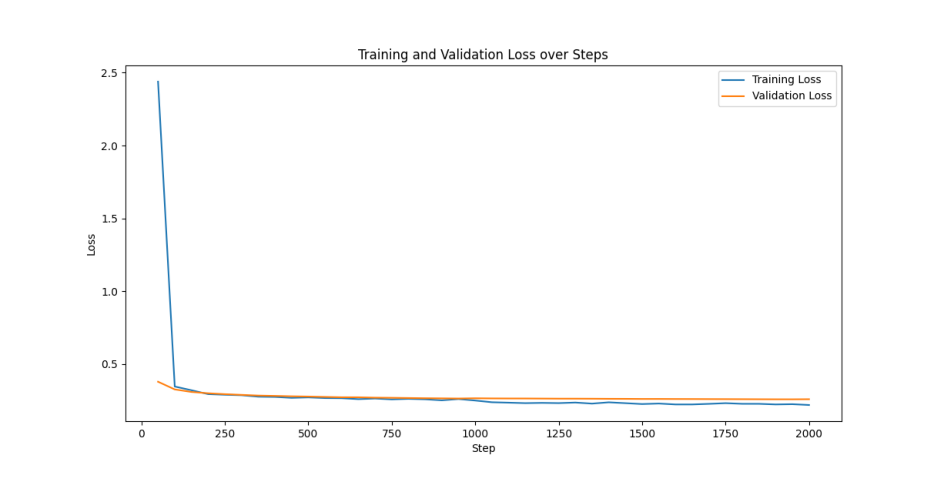

In [14]:
# Plot the training and validation loss
if train_now:
    steps = sorted(set(log['step'] for log in log_history if 'step' in log))
    losses = [log['loss'] for log in log_history if 'loss' in log]
    val_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]

    plt.figure(figsize=(12, 6))
    plt.plot(steps, losses, label='Training Loss')
    plt.plot(steps, val_losses, label='Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss over Steps')

    # Save the plot in PATH_RESULTS
    loss_curve_path = os.path.join(PATH_RESULTS, "loss_curves.png")
    plt.savefig(loss_curve_path, format='png')
    plt.show()

    print(f"Loss curve saved in {loss_curve_path}")
else: 
    img = mpimg.imread("LLM_Session2/Models/loss_curves.png")
    # Display the image
    plt.figure(figsize=(12, 6))
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

## Trying Out the Chatbot

Now that we have fine-tuned our GPT-2 model, it's time to test it in an interactive way! In this section, we'll create a simple function that allows you to have a conversation with the chatbot. The goal is to observe how the model responds to different prompts and how well it can maintain the context of a conversation.
The MultiWOZ dataset contains mostly factual information about booking a hotel room or travelling between cities.

However, GPT-2 is pretrained on a huge dataset and contains encoded informaiton. 
Does it recognise historical figures, such as Albert Einstain or Isac Newton?

#### Controll the output of the Chatbot

- Greedy Search Decoding (Deterministic)

    The simplest decoding method to get discrete tokens from a model’s continuous output is to greedily select the token with the highest probability at each timestep.
    
    ```python
    model.generate(
    input_ids,
    max_length=max_length,
    do_sample=False,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.convert_tokens_to_ids('<|endofturn|>'))

- Sampling Methods (Porbabilistic)

    The simplest sampling method is to randomly sample from the probability distribution of the model’s outputs over the full vocabulary at each timestep. This approach makes the model more 'creative'. Here, we suggest to restrict the acces to the `top_p` and `top_k` number of possible tokens.
    Additionally, we can control the selection of the `temperature`. When T ≪ 1, the distribution becomes peaked around the origin and the rare tokens are suppressed. On the other hand, when T ≫ 1, the distribution flattens out and each token becomes equally likely.

    ```python 
    model.generate(input_ids, 
    max_length=max_length,
    do_sample=True, temperature=2, top_k=50, 
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.convert_tokens_to_ids('<|endofturn|>'))

In [29]:
# Make sure the model is in evaluation mode
model.eval()
model.to(device)


def chat_with_bot(input_text, previous_chat,count,max_length=256):
    # Encode the input text based on whether it's the first message or not
    if count == 0:
        input_text = f"<|user|> {input_text}<|system|>"
    else:
        input_text = f"{previous_chat}<|user|> {input_text}<|system|>"
    
    # print("INPUT: ",count, input_text)
    # Encode the input text
    input_ids = tokenizer.encode(input_text, return_tensors="pt").to(device)


    # Generate the response
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=1,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.convert_tokens_to_ids('<|endofturn|>'),
    )

    # Decode the output, skipping special tokens
    response = tokenizer.decode(
        output[:, input_ids.shape[-1] :][0], skip_special_tokens=True
    )
    return response, input_text + response


In [30]:
print("Start chatting with the bot! Type 'exit' to stop.")
previous_chat = ""
count = 0
while True:
    prompt = input("You: ")
    if prompt.lower() == 'exit':
        break
    response, previous_chat = chat_with_bot(prompt, previous_chat,count)
    count+=1
    cleaned_response = response.replace(prompt, '').strip() if prompt in response else response 
    print(f"GPT2chat: {cleaned_response}")

Start chatting with the bot! Type 'exit' to stop.
GPT2chat:  I am looking for a place to stay. The hotel should be in the type of guesthouse and should include free parking.  I have several


### Compare the above fine-tuned GPT2chat with the default pre-trained text generator GPT2text (allowing creative texts):

In [19]:
transformers_logging.set_verbosity_error()
tokenizer_pretrained = GPT2Tokenizer.from_pretrained('gpt2')
model_pretrained = GPT2LMHeadModel.from_pretrained("gpt2")
model_pretrained.eval()
model_pretrained.to(device)

def generate_response_pretrained(prompt, model_pretrained, tokenizer_pretrained, temperature=0.7):
    inputs = tokenizer_pretrained.encode(prompt, return_tensors="pt").to(device)
    outputs = model_pretrained.generate(
        inputs,
        max_new_tokens=100,
        num_return_sequences=1,
        no_repeat_ngram_size=2,
        do_sample=True,
        top_k=150,
        top_p=0.9,
        temperature=temperature,
    )
    response = tokenizer_pretrained.decode(outputs[0], skip_special_tokens=True)
    return response

In [21]:
Sugested_prompt="In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English."

response = generate_response_pretrained(Sugested_prompt, model_pretrained, tokenizer_pretrained)
print(f"GPT2text: {response}")

GPT2text: In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.

"This is the first time that we have ever found a unicorn that speaks perfect Spanish," says Michael Zaretsky, the lead researcher on the study. "The unicorn is a hybrid of a European and American unicorn, which means that it's one of the only unicurs to speak the language. It's the best known of these unicurals, and this is only the beginning."
...
 In addition to communicating with the animal, researchers also found that unic
